In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import colors, cm
import glob
from datetime import datetime, timedelta

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union, List

import hoomd
from hoomd.neb_plugin import neb
import gsd.hoomd
import freud
import schmeud
from schmeud._schmeud import dynamics as schmeud_dynamics

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib
from collections import defaultdict

import os
import sys

import signac

from dataclasses import dataclass
from dataclasses_json import dataclass_json

import fresnel
import PIL.Image
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "xx-large"
from monk import nb, prep, pair, render, utils, workflow, grid

config = workflow.get_config()
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'ref_sim_temps': [0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7, 0.75, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], 'avail_seed': 18, 'alpha_iters': 40, 'dt': 0.001, 'usteps': 1000, '_status': {}}

In [2]:
import hoomd.pair_plugin.pair as pair_plugin

In [3]:
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "xx-large"

In [4]:
from monk import nb, prep, pair, render, utils, workflow, grid

config = workflow.get_config()

In [5]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'ref_sim_temps': [0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7, 0.75, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], 'avail_seed': 18, 'alpha_iters': 40, 'dt': 0.001, 'usteps': 1000, '_status': {}}

In [6]:
for idx, job in enumerate(project.find_jobs({"delta": 0.0, "replica": 0})):
    print(idx, job.doc)
    doc = job.doc
    sp = job.sp

    dt = project.doc["dt"]

    runs = sorted(glob.glob(job.fn("short_runs/temp-*/")))[2:]
    for run in runs:
        print(run)
        temp = float(utils.extract_between(run, "temp-", "/"))
        fire_file = run + "fire_traj.gsd"
        # print(run)
        traj = gsd.hoomd.open(fire_file, "rb")
        df = pd.read_parquet(run + "struct-descr.parquet")

        break

0 {'seed': 0, 'init': True, 'temps': [2.0, 1.8, 1.6, 1.4, 1.2, 1.0, 0.9, 0.8, 0.75, 0.7, 0.67, 0.64, 0.61, 0.58, 0.55, 0.53, 0.51, 0.49, 0.47, 0.45, 0.43, 0.41], 'alpha_ests': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0354841942940312, 1.3397690122883383, 1.9147213152655829, 2.427651106103333, 3.2650328444742174, 4.051542695887625, 5.218161511196287, 7.044415153987661, 10.10020001455888, 15.65947793481358, 22.171066058445877, 33.176064452520336, 53.117878466989104, 92.44383930410444, 178.47690107882985, 392.5634880273459, 1018.9213055070264], 'checkpoint': {'temp_idx': 20, 'start_tstep': 17557689}, 'fire_applied': True, 'training_sfs_computed': True, 'softness_trained': True, 'analysis_sfs_computed': True, 'const_shear_ran': True}
/media/ian/Data2/monk/mlj-production/workspace/1fd668d1992cea34bb8de5b9cf4bc990/short_runs/temp-0.49/


In [7]:
nlist = hoomd.md.nlist.Tree(0.3)
mlj = pair.KA_ModLJ(nlist, 0.0)
forces = [mlj]
dev = "gpu"
filter = hoomd.filter.All()

snap2snap = hoomd.Snapshot.from_gsd_snapshot
device = hoomd.device.GPU()

neb_driver = neb.NEBDriver(snap2snap(traj[20], device.communicator), snap2snap(traj[21], device.communicator), n_images=10, forces=forces, filter=filter, device=dev)
neb_driver.k = 100.0

In [8]:
start = neb_driver._neb_sims[0]
end = neb_driver._neb_sims[-1]

0: 0.42910146713256836
1: 0.15785551071166992
2: 0.11033868789672852
3: 0.10197234153747559
4: 0.0995943546295166
5: 0.10161256790161133
6: 0.0975193977355957
7: 0.0960226058959961
8: 0.09432554244995117
9: 0.09864497184753418
10: 0.09347105026245117
11: 0.09283089637756348
12: 0.09121108055114746
13: 0.0836949348449707
14: 0.08286190032958984
15: 0.07919120788574219
16: 0.08050942420959473
17: 0.07902956008911133
18: 0.07993602752685547
19: 0.07879972457885742
20: 0.08007955551147461
21: 0.07911968231201172
22: 0.08015823364257812
23: 0.07888650894165039
24: 0.0800480842590332
25: 0.07884931564331055
26: 0.08024811744689941
27: 0.07876157760620117
28: 0.07989931106567383
29: 0.07889628410339355
30: 0.0800936222076416
31: 0.07873010635375977
32: 0.08014106750488281
33: 0.07886505126953125
34: 0.0800318717956543
35: 0.07891321182250977
36: 0.08015918731689453
37: 0.07897663116455078
38: 0.07999181747436523
39: 0.07888102531433105
40: 0.0801551342010498
41: 0.07892060279846191
42: 0.0798

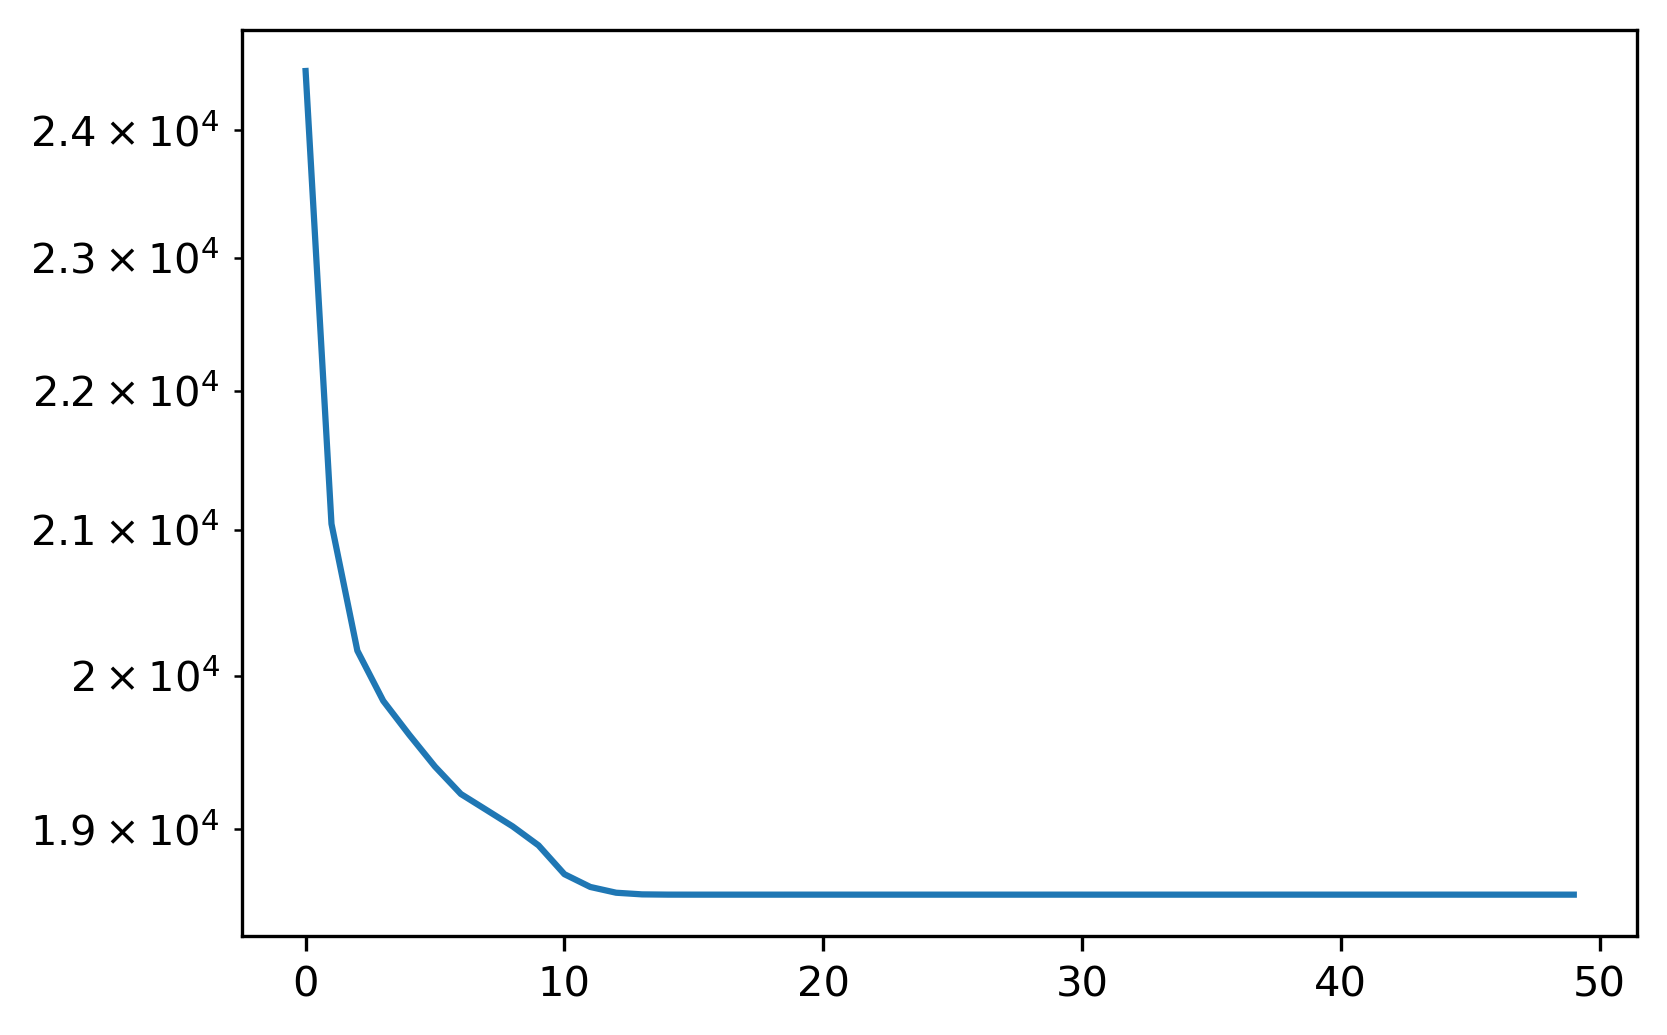

In [9]:
energy = []

end.operations.integrator.nudge = False
for i in range(50):
    start_time = time.time()
    end.run(500)
    print(f"{i}:", time.time() - start_time)
    energy.append(end.operations.integrator.energy)

mmin = np.min(energy)
mmin -= 0.1 * np.abs(mmin)
plt.plot(np.array(energy) - mmin)
plt.yscale('log')

0: 0.4125535488128662
1: 0.15626883506774902
2: 0.10850119590759277
3: 0.10497927665710449
4: 0.10373330116271973
5: 0.10230779647827148
6: 0.0930335521697998
7: 0.09365272521972656
8: 0.09389710426330566
9: 0.09272527694702148
10: 0.08935761451721191
11: 0.08537006378173828
12: 0.08449196815490723
13: 0.09096145629882812
14: 0.09212565422058105
15: 0.08356046676635742
16: 0.08349943161010742
17: 0.0854489803314209
18: 0.08365583419799805
19: 0.07887411117553711
20: 0.08051085472106934
21: 0.07874774932861328
22: 0.07978296279907227
23: 0.07867670059204102
24: 0.07977294921875
25: 0.07876229286193848
26: 0.07984304428100586
27: 0.07880568504333496
28: 0.07975101470947266
29: 0.07874155044555664
30: 0.0798654556274414
31: 0.07876849174499512
32: 0.07985734939575195
33: 0.07874393463134766
34: 0.07989001274108887
35: 0.0787346363067627
36: 0.07999420166015625
37: 0.07880949974060059
38: 0.08005142211914062
39: 0.07877516746520996
40: 0.08000302314758301
41: 0.07859253883361816
42: 0.0799

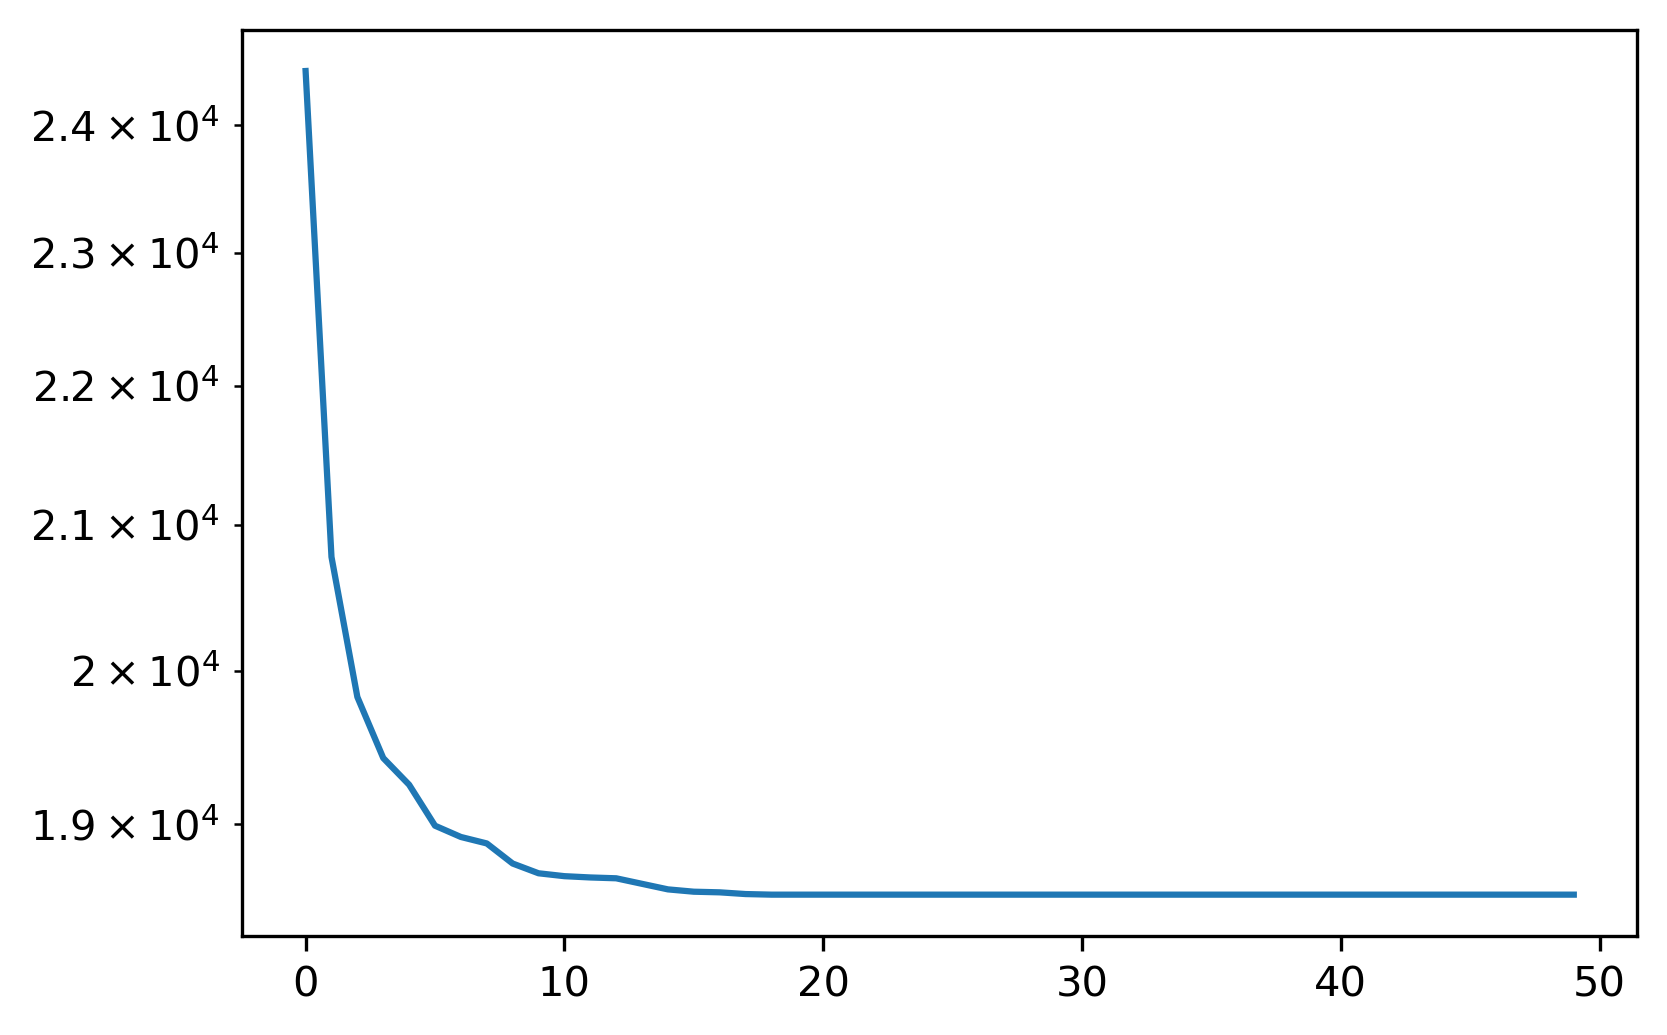

In [10]:

start.operations.integrator.nudge = False
energy = []
for i in range(50):
    start_time = time.time()
    start.run(500)
    print(f"{i}:", time.time() - start_time)
    energy.append(start.operations.integrator.energy)
# start.operations.integrator.nudge = True


mmin = np.min(energy)
mmin -= 0.1 * np.abs(mmin)
plt.plot(np.array(energy) - mmin)
plt.yscale('log')

In [11]:
start.operations.integrator.nudge = True
end.operations.integrator.nudge = True

In [12]:
def d_omega(snap1, snap2):
    box = freud.box.Box.from_box(snap1.configuration.box)
    pos1 = snap1.particles.position
    pos2 = snap2.particles.position
    diff = box.wrap(pos2 - pos1)
    return np.linalg.norm(diff)

1: 0.9889168739318848
2: 0.47508859634399414
3: 0.4598569869995117
4: 0.4492642879486084
5: 0.46320390701293945
6: 0.4648263454437256
7: 0.45883631706237793
8: 0.4680666923522949
9: 0.4547147750854492
10: 0.38349151611328125
11: 0.35152745246887207
12: 0.3373429775238037
13: 0.34839415550231934
14: 0.34469056129455566
15: 0.34870219230651855
16: 0.34465837478637695
17: 0.349104642868042
18: 0.3347020149230957
19: 0.3399190902709961
20: 0.3330709934234619
21: 0.3394279479980469
22: 0.3285238742828369
23: 0.32991695404052734
24: 0.3333461284637451
25: 0.3276817798614502
26: 0.3226313591003418
27: 0.3321678638458252
28: 0.3249776363372803
29: 0.3326294422149658
30: 0.3151977062225342
31: 0.3319261074066162
32: 0.314516544342041
33: 0.32241368293762207
34: 0.3174471855163574
35: 0.30884790420532227
36: 0.30890321731567383
37: 0.3238704204559326
38: 0.3074038028717041
39: 0.3232700824737549
40: 0.31468820571899414
41: 0.31783628463745117
42: 0.3140397071838379
43: 0.3108842372894287
44: 0.3

Text(0.5, 0, 'Node i')

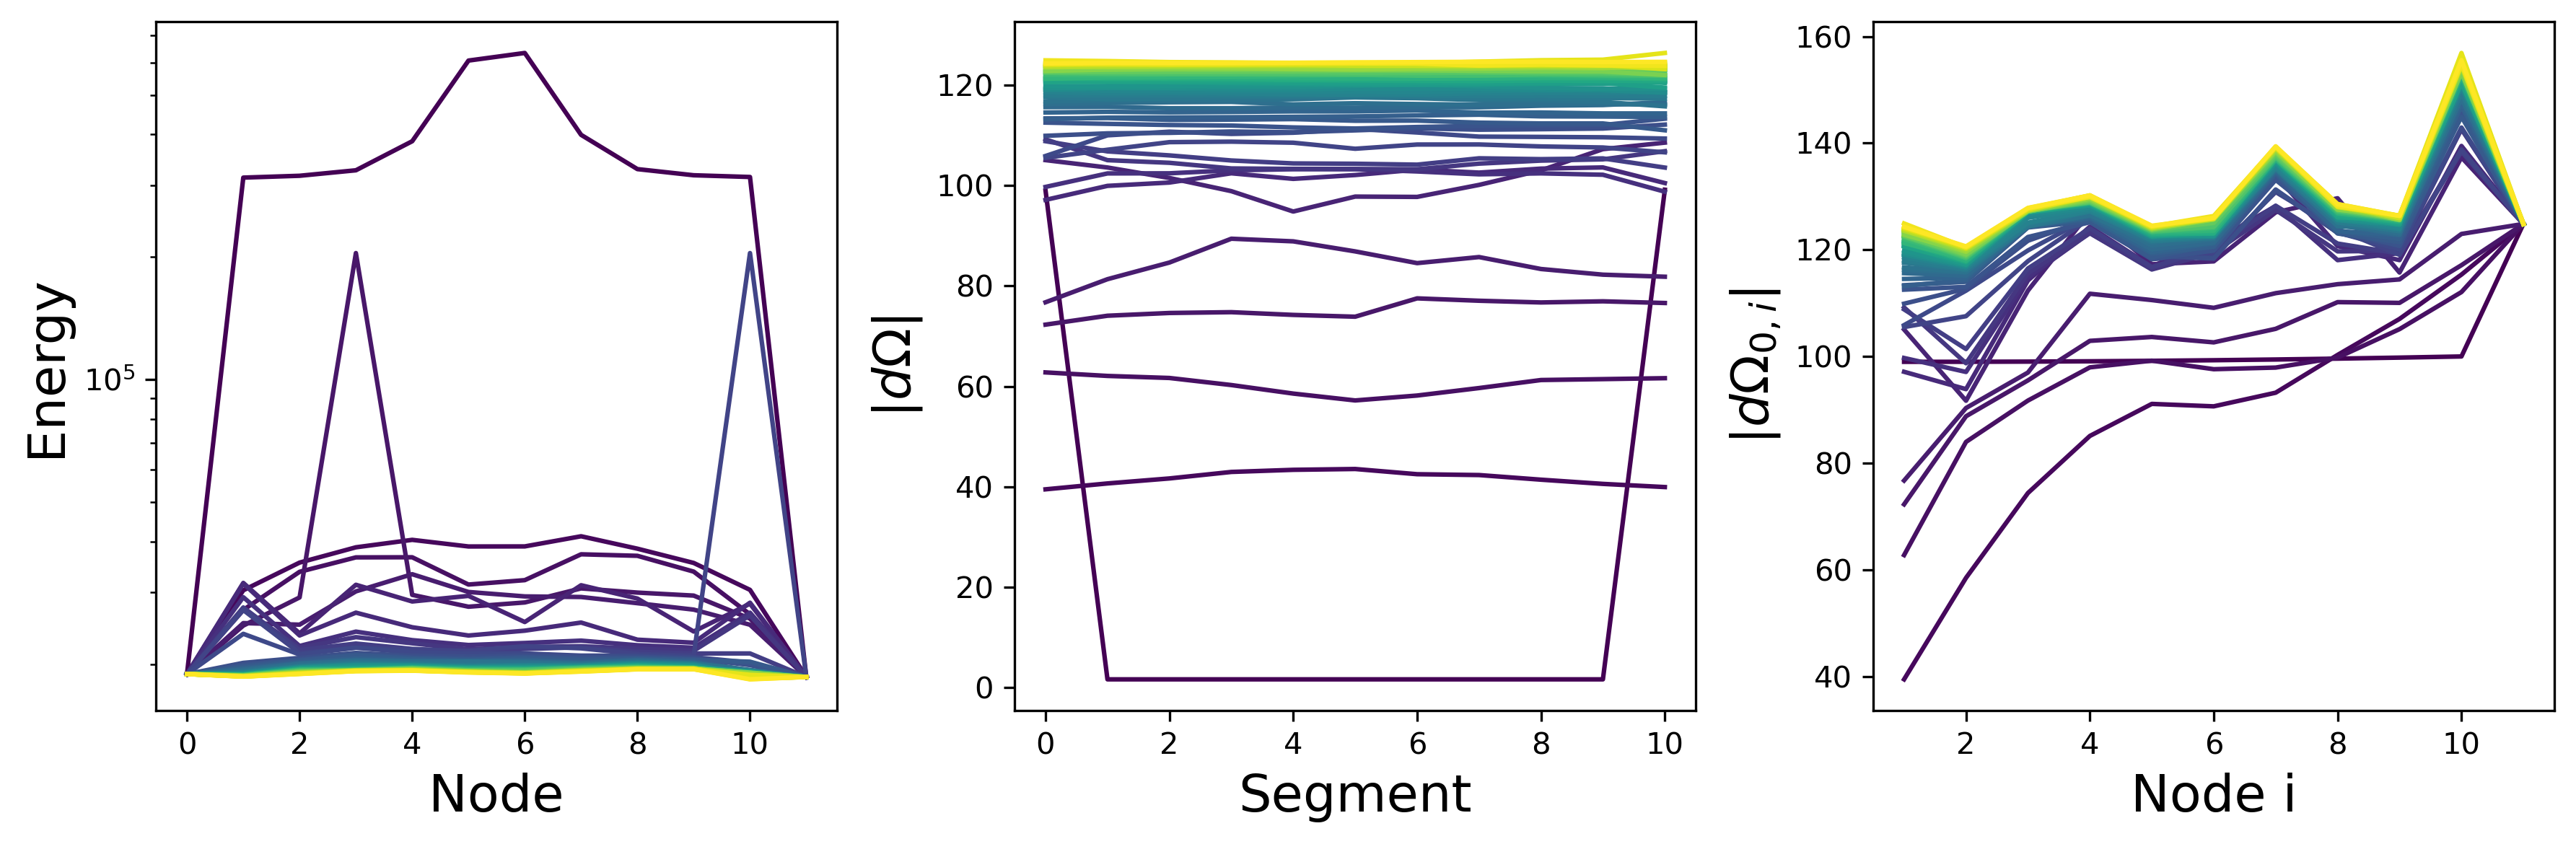

In [13]:
cmap = cm.viridis
runs = 50
norm = colors.Normalize(vmin=0, vmax=runs)

fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

energy = []
dists = []
other_dists = []
nodes = neb_driver.nodes
for i in range(len(nodes)-1):
    # print(len(sim.operations.integrator.forces))
    # sim.operations.integrator.reset()
    ps_dist = d_omega(nodes[i].state.get_snapshot(), nodes[i+1].state.get_snapshot())
    ps_dist = np.where(np.isnan(ps_dist), 0, ps_dist)
    dists.append(ps_dist)
    energy.append(nodes[i].operations.integrator.forces[0].energy)
energy.append(nodes[-1].operations.integrator.forces[0].energy)

iter = list(range(1, len(nodes)))
for i in iter:
    ps_dist = d_omega(nodes[0].state.get_snapshot(), nodes[i].state.get_snapshot())
    other_dists.append(ps_dist)

mmin = np.min(energy)
mmin -= 0.1 * np.abs(mmin)

axs[0].plot(np.array(energy) - mmin, color=cmap(norm(0)))
axs[1].plot(dists, color=cmap(norm(0)))
axs[2].plot(iter, other_dists, color=cmap(norm(0)))

for j in range(1, runs+1):
    start = time.time()
    neb_driver.run(100)
    print(f"{j}:", time.time() - start)
    energy = []
    dists = []
    other_dists = []
    nodes = neb_driver.nodes
    for i in range(len(nodes)-1):
        # print(len(sim.operations.integrator.forces))
        # sim.operations.integrator.reset()
        ps_dist = d_omega(nodes[i].state.get_snapshot(), nodes[i+1].state.get_snapshot())
        ps_dist = np.where(np.isnan(ps_dist), 0, ps_dist)
        dists.append(ps_dist)
        energy.append(nodes[i].operations.integrator.forces[0].energy)
    energy.append(nodes[-1].operations.integrator.forces[0].energy)

    iter = list(range(1, len(nodes)))
    for i in iter:
        ps_dist = d_omega(nodes[0].state.get_snapshot(), nodes[i].state.get_snapshot())
        other_dists.append(ps_dist)

    axs[0].plot(np.array(energy) - mmin, color=cmap(norm(j)))
    axs[1].plot(dists, color=cmap(norm(j)))
    axs[2].plot(iter, other_dists, color=cmap(norm(j)))
axs[0].set_ylabel("Energy")
axs[0].set_yscale("log")
axs[0].set_xlabel("Node")
axs[1].set_ylabel(r"$|d\Omega|$")
axs[1].set_xlabel("Segment")
axs[2].set_ylabel(r"$|d\Omega_{0,i}|$")
axs[2].set_xlabel("Node i")

1: 0.3215007781982422
2: 0.301253080368042
3: 0.31518101692199707
4: 0.2949230670928955
5: 0.3126187324523926
6: 0.2900536060333252
7: 0.3029203414916992
8: 0.2929685115814209
9: 0.309999942779541
10: 0.2995333671569824
11: 0.30306196212768555
12: 0.2993955612182617
13: 0.29666852951049805
14: 0.29308557510375977
15: 0.3092989921569824
16: 0.2978794574737549
17: 0.3014345169067383
18: 0.2940239906311035
19: 0.30335497856140137
20: 0.2950749397277832
21: 0.3047635555267334
22: 0.2978513240814209
23: 0.3025040626525879
24: 0.29732394218444824
25: 0.30333399772644043
26: 0.29830026626586914
27: 0.29998087882995605
28: 0.29459190368652344
29: 0.300506591796875
30: 0.2933015823364258
31: 0.30229616165161133
32: 0.2937498092651367
33: 0.30312061309814453
34: 0.28917694091796875
35: 0.3075394630432129
36: 0.2996501922607422
37: 0.30255818367004395
38: 0.2928507328033447
39: 0.30608320236206055
40: 0.2979702949523926
41: 0.307206392288208
42: 0.289794921875
43: 0.30431556701660156
44: 0.293760

Text(0.5, 0, 'Node i')

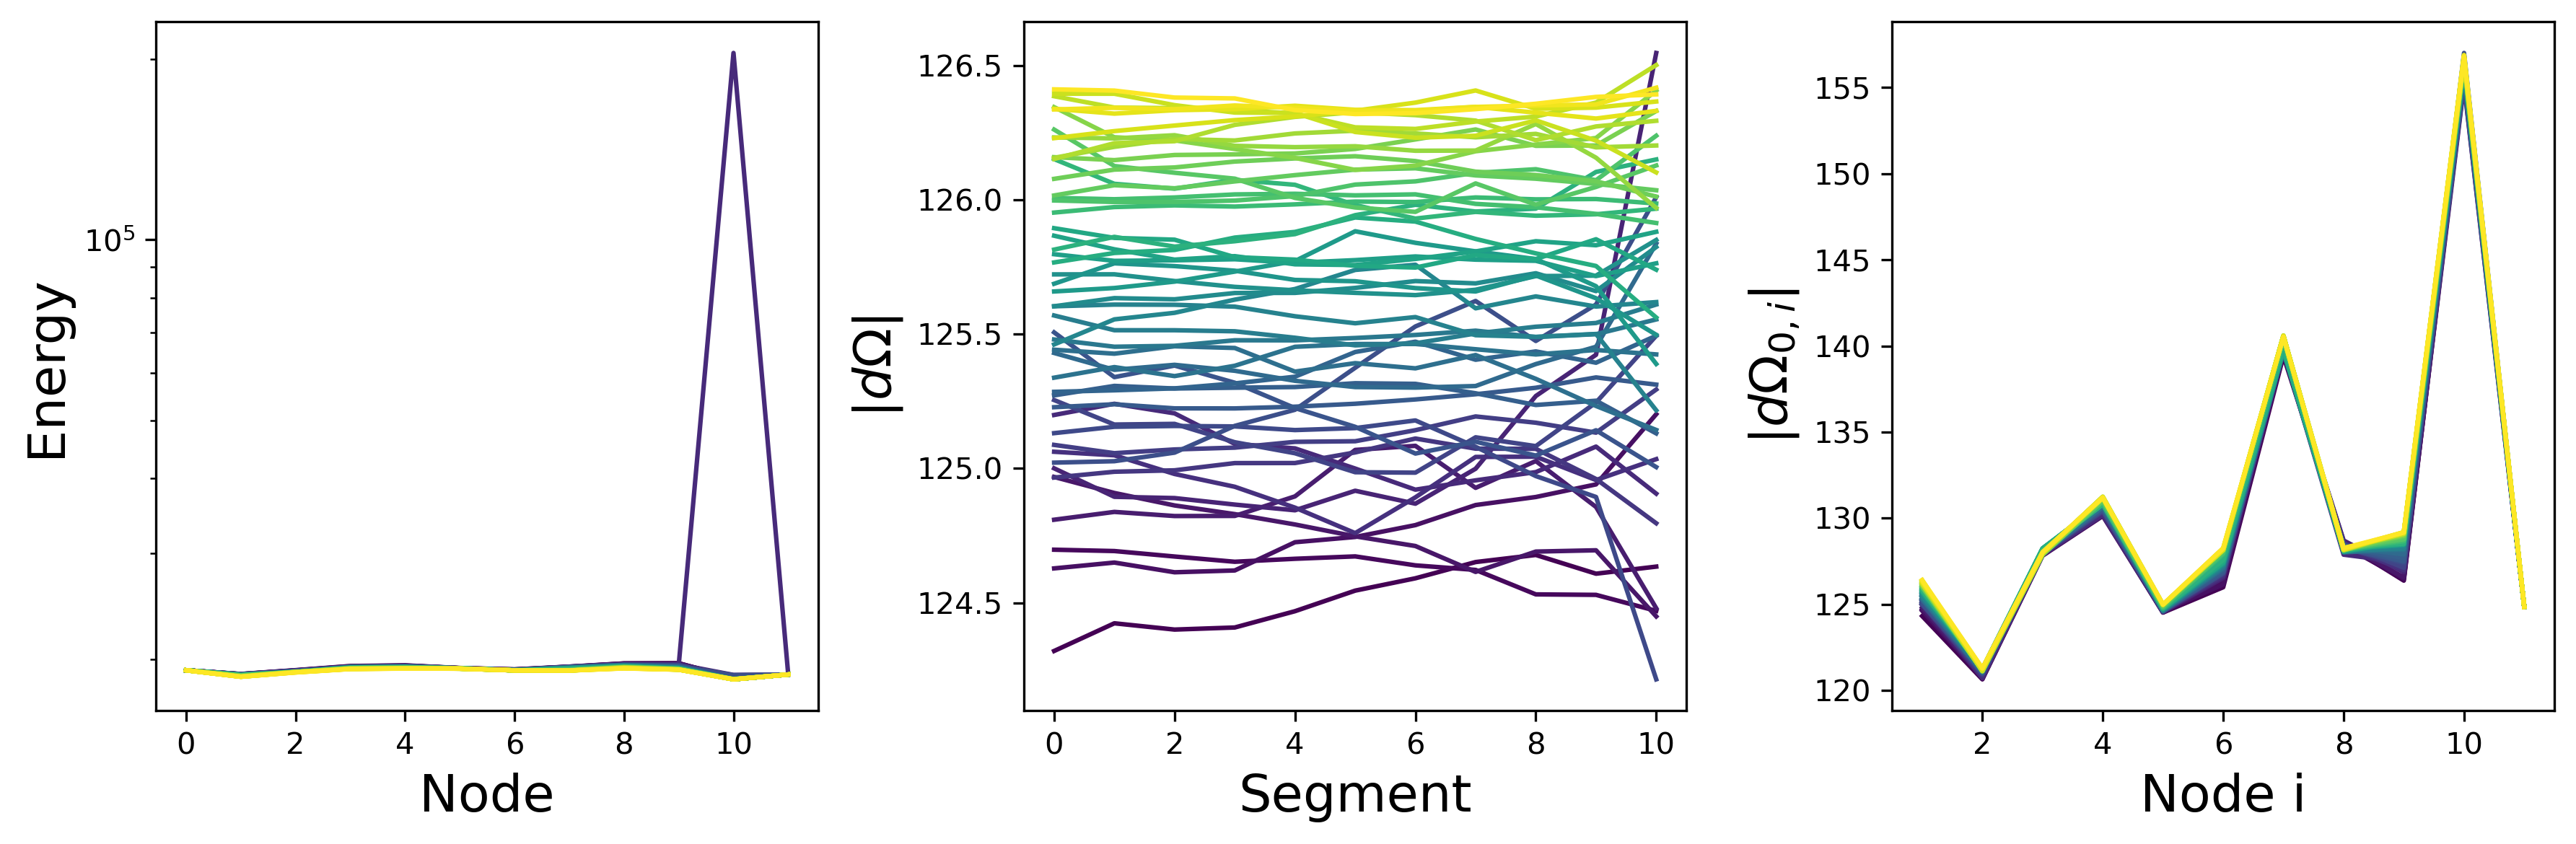

In [14]:
cmap = cm.viridis
runs = 50
norm = colors.Normalize(vmin=0, vmax=runs)

fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

energy = []
dists = []
other_dists = []
nodes = neb_driver.nodes
for i in range(len(nodes)-1):
    # print(len(sim.operations.integrator.forces))
    # sim.operations.integrator.reset()
    ps_dist = d_omega(nodes[i].state.get_snapshot(), nodes[i+1].state.get_snapshot())
    ps_dist = np.where(np.isnan(ps_dist), 0, ps_dist)
    dists.append(ps_dist)
    energy.append(nodes[i].operations.integrator.forces[0].energy)
energy.append(nodes[-1].operations.integrator.forces[0].energy)

iter = list(range(1, len(nodes)))
for i in iter:
    ps_dist = d_omega(nodes[0].state.get_snapshot(), nodes[i].state.get_snapshot())
    other_dists.append(ps_dist)

mmin = np.min(energy)
mmin -= 0.1 * np.abs(mmin)

axs[0].plot(np.array(energy) - mmin, color=cmap(norm(0)))
axs[1].plot(dists, color=cmap(norm(0)))
axs[2].plot(iter, other_dists, color=cmap(norm(0)))

for j in range(1, runs+1):
    start = time.time()
    neb_driver.run(100)
    print(f"{j}:", time.time() - start)
    energy = []
    dists = []
    other_dists = []
    nodes = neb_driver.nodes
    for i in range(len(nodes)-1):
        # print(len(sim.operations.integrator.forces))
        # sim.operations.integrator.reset()
        ps_dist = d_omega(nodes[i].state.get_snapshot(), nodes[i+1].state.get_snapshot())
        ps_dist = np.where(np.isnan(ps_dist), 0, ps_dist)
        dists.append(ps_dist)
        energy.append(nodes[i].operations.integrator.forces[0].energy)
    energy.append(nodes[-1].operations.integrator.forces[0].energy)

    iter = list(range(1, len(nodes)))
    for i in iter:
        ps_dist = d_omega(nodes[0].state.get_snapshot(), nodes[i].state.get_snapshot())
        other_dists.append(ps_dist)

    axs[0].plot(np.array(energy) - mmin, color=cmap(norm(j)))
    axs[1].plot(dists, color=cmap(norm(j)))
    axs[2].plot(iter, other_dists, color=cmap(norm(j)))
axs[0].set_ylabel("Energy")
axs[0].set_yscale("log")
axs[0].set_xlabel("Node")
axs[1].set_ylabel(r"$|d\Omega|$")
axs[1].set_xlabel("Segment")
axs[2].set_ylabel(r"$|d\Omega_{0,i}|$")
axs[2].set_xlabel("Node i")